# Stock data analysis and prediction
(Code on pure arima. Plots generated by this file was put into Jingming Cheng/Running Results.xlsx)

This paper will analyze and predict stock data based on the ARIMA model, including data processing, stationarity test, model order determination and correction, and prediction of future trends.

## 1. Data source

The data comes from stock market transaction data, including the following fields:

- **date**: date

- **open**: opening price

- **high**: highest price

- **low**: lowest price

- **close**: closing price

- **volume**: trading volume


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, q_stat
from sklearn.metrics import mean_squared_error
import os

# Read data
BASE_DIR = os.path.abspath(os.path.join("..", "..","hongzhen xu","input data"))
stock = "VZ"
print(BASE_DIR)
df = pd.read_csv(BASE_DIR + '\Reversed_' + stock + '_Data_with_PCA.csv')   
df.head()
df.index = pd.to_datetime(df.index)   #Indexing df.index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
ts = df['open']

# Split the dataset into 80% training set and 20% test set
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

ts.head()

e:\PG Year 2\Semester 1\CS6140 10931 Machine Learning\Project\stockPredictModelsProject\hongzhen xu\input data


timestamp
2014-09-30    49.67
2014-10-01    49.73
2014-10-02    49.70
2014-10-03    49.70
2014-10-06    49.95
Name: open, dtype: float64

## 2. Problem Exploration

The goal is to build an ARIMA model to predict future stock opening price trends.

In [87]:
plt.rcParams['font.sans-serif'] = ['simhei']  # Used to display Chinese labels normally
plt.rcParams['axes.unicode_minus'] = False   # Used to display the negative sign normally

## 3. Stationarity test

By drawing time series graphs and autocorrelation graphs, and performing ADF unit root tests, we can determine whether the data is stationary.

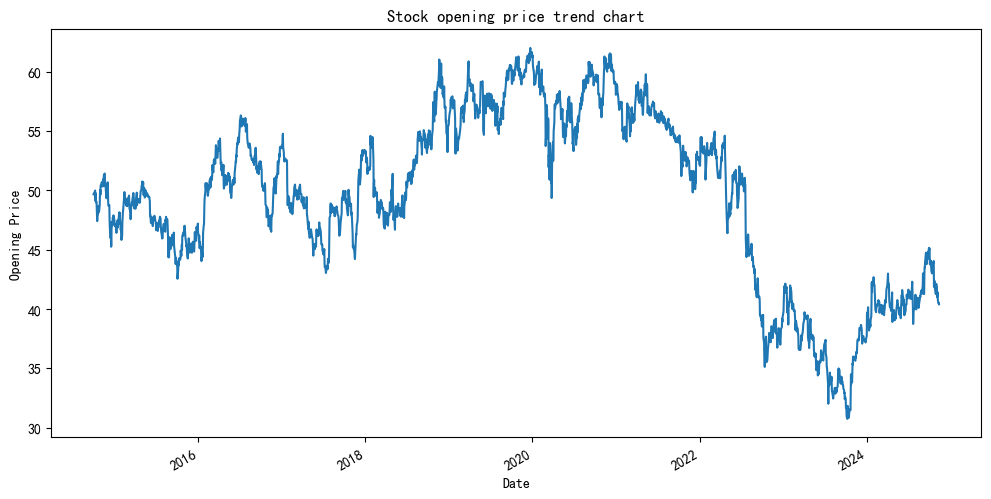

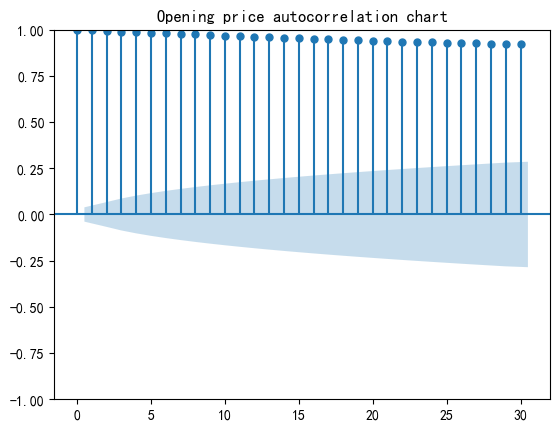

ADF test result: Test Statistic = -1.8255351990404265, p-value = 0.36785987917103113
Critical Values:
	1%: -3.4335627358346366
	5%: -2.862959228246899
	10%: -2.567525534009848


In [88]:
# Draw a trend chart of opening prices
plt.figure(figsize=(12, 6))
ts.plot(title="Stock opening price trend chart", ylabel="Opening Price", xlabel="Date")
plt.show()

# Autocorrelation plot
plot_acf(ts, lags=30, title="Opening price autocorrelation chart")
plt.show()

# ADF test of unit root
adf_test = adfuller(train)
print(f"ADF test result: Test Statistic = {adf_test[0]}, p-value = {adf_test[1]}")
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"\t{key}: {value}")

## 4. Difference operation

Perform first-order difference on the data to eliminate trend and test stationarity again.

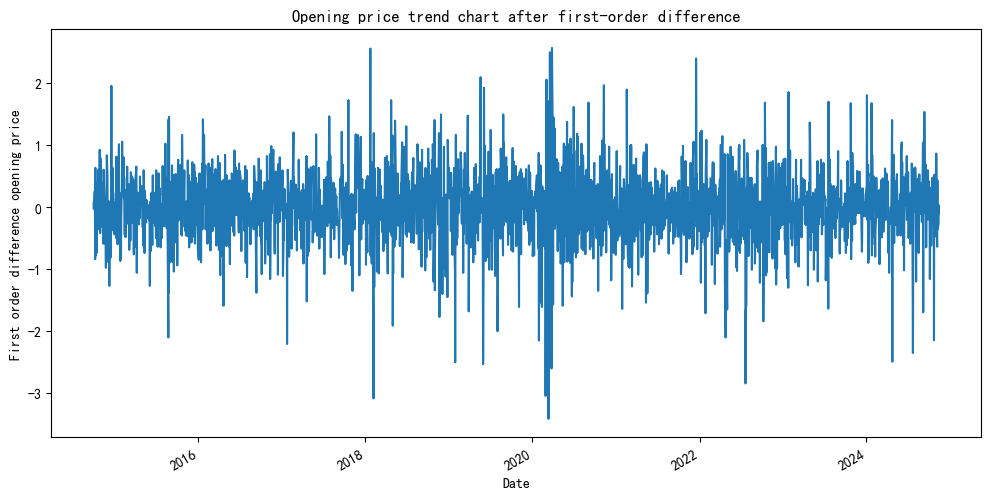

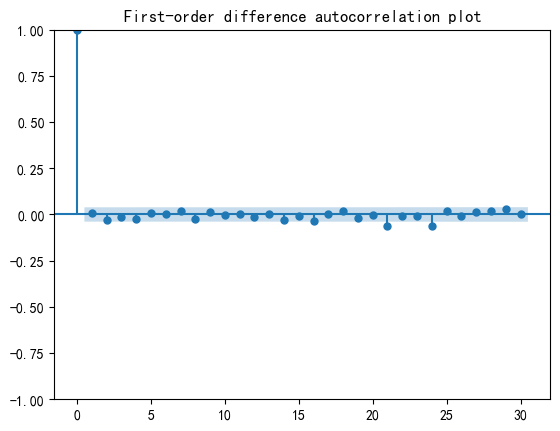

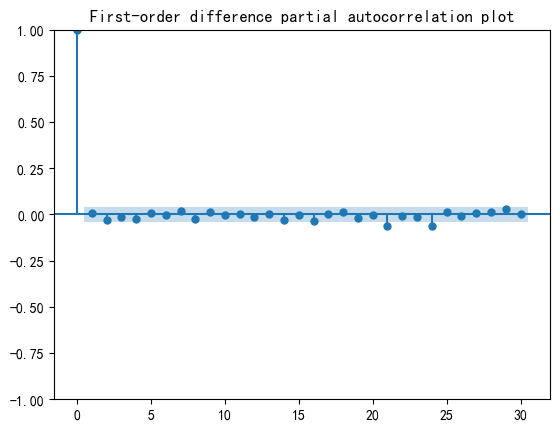

ADF test result (After difference):Test Statistic = -1.8255351990404265, p-value = 0.36785987917103113
Critical Values:
	1%: -3.4335627358346366
	5%: -2.862959228246899
	10%: -2.567525534009848


In [89]:
# First Difference
D_ts = ts.diff().dropna()
D_ts.columns = [u'open difference']

# Draw the timing diagram after differential
plt.figure(figsize=(12, 6))
D_ts.plot(title="Opening price trend chart after first-order difference", ylabel="First order difference opening price", xlabel="Date")
plt.show()

# Autocorrelation and partial autocorrelation after difference
plot_acf(D_ts, lags=30, title="First-order difference autocorrelation plot")
plt.show()

plot_pacf(D_ts, lags=30, title="First-order difference partial autocorrelation plot")
plt.show()

# ADF单位根检验
adf_test_diff = adfuller(train)
print(f"ADF test result (After difference):Test Statistic = {adf_test_diff[0]}, p-value = {adf_test_diff[1]}")
print("Critical Values:")
for key, value in adf_test_diff[4].items():
    print(f"\t{key}: {value}")

In [90]:
# Perform LjungBox test on the differenced data
from statsmodels.tsa import stattools # Perform LjungBox test on data that reaches stationarity after difference
LjungBox=stattools.q_stat(stattools.acf(D_ts)[1:12],len(D_ts)) # Display white noise test results, return statistics and p-values
LjungBox[1][-1]

0.8317551979558521

From the running results, we can know that p-value=0.8317551979558521>0.05, so the original hypothesis cannot be rejected, that is to say, the opening price sequence after difference is a stationary white noise sequence.

## 5. Model order determination

Select the optimal order of the model through AIC/BIC.

In [91]:
# 使用AIC选择最佳阶数
from statsmodels.tsa.stattools import arma_order_select_ic
order = arma_order_select_ic(D_ts, max_ar=6, max_ma=4, ic='aic')['aic_min_order']
print(f"Optimal model order: {order}")

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

Optimal model order: (2, 2)


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 6. Model Modification

Establish an ARIMA model based on the selected order and diagnose its rationality.

In [92]:
# Building an ARIMA Model
model = ARIMA(ts, order=(order[0], 1, order[1]))
result = model.fit()
print(result.summary())

# Model diagnostics
print("Confidence interval: ")
print(result.conf_int())

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   open   No. Observations:                 2549
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2200.057
Date:                Mon, 09 Dec 2024   AIC                           4410.114
Time:                        02:15:00   BIC                           4439.329
Sample:                             0   HQIC                          4420.710
                               - 2549                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0548      0.077      0.709      0.478      -0.097       0.206
ar.L2          0.8668      0.074     11.637      0.000       0.721       1.013
ma.L1         -0.0506      0.070     -0.720      0.4

In [93]:
result.conf_int() # Model diagnostics

,0,1
ar.L1,-0.096630,0.206204
ar.L2,0.720825,1.012804
ma.L1,-0.188244,0.087112
ma.L2,-1.032840,-0.761365
sigma2,0.317742,0.340695


## 7. Model Prediction

Predict future stock prices and plot the results.

The prediction results have been saved to arima_forecast_results_VZ.xlsx
Predicted value: 
 timestamp
2022-11-03    40.406646
2022-11-04    40.446587
2022-11-07    40.454537
2022-11-08    40.489594
2022-11-09    40.498405
                ...    
2024-11-07    40.989595
2024-11-08    40.989595
2024-11-11    40.989595
2024-11-12    40.989595
2024-11-13    40.989595
Name: forecast, Length: 510, dtype: float64
Standard error: 
 timestamp
2022-11-03    0.573776
2022-11-04    0.813156
2022-11-07    0.986737
2022-11-08    1.134623
2022-11-09    1.258823
                ...   
2024-11-07    8.851649
2024-11-08    8.859931
2024-11-11    8.868206
2024-11-12    8.876472
2024-11-13    8.884731
Name: stderr, Length: 510, dtype: float64
Confidence interval: 
             lower_bound  upper_bound
timestamp                           
2022-11-03    39.282046    41.531247
2022-11-04    38.852802    42.040372
2022-11-07    38.520533    42.388541
2022-11-08    38.265733    42.713454
2022-11-09    38.03111

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


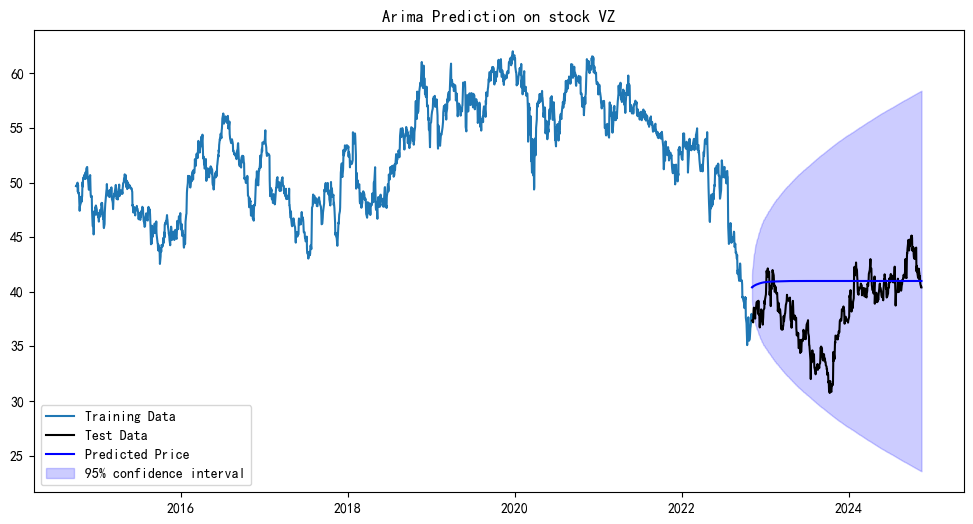

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Make predictions on the test set
forecast = result.forecast(steps=len(test))  # Make predictions on the test set
forecast_var = result.get_forecast(steps=len(test)).var_pred_mean.values  # Variance
stderr = np.sqrt(forecast_var)  # Standard error

# Construct a DataFrame containing the predicted value, standard error, and confidence interval
conf_int_df = pd.DataFrame({
    "forecast": forecast.values,
    "stderr": stderr,
    "lower_bound": forecast.values - 1.96 * stderr,
    "upper_bound": forecast.values + 1.96 * stderr
}, index=test.index)  # Set the table header to date index

# Save as Excel file
output_file = "arima_forecast_results_" + stock + ".xlsx"
conf_int_df.to_excel('result/' + str(stock) + '/' + output_file)
print(f"The prediction results have been saved to {output_file}")

# Print Results
print("Predicted value: \n", conf_int_df["forecast"])
print("Standard error: \n", conf_int_df["stderr"])
print("Confidence interval: \n", conf_int_df[["lower_bound", "upper_bound"]])

# Evaluating Model Performance
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
r2 = r2_score(test, forecast)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean absolute error (MAE): {mae}")
print(f"Coefficient of determination (R^2): {r2}")

# Plot the training set, test set, predicted values, and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train, label="Training Data")
plt.plot(test, label="Test Data", color="black")
plt.plot(test.index, forecast, label="Predicted Price", color="blue")
plt.fill_between(test.index, conf_int_df["lower_bound"], conf_int_df["upper_bound"], color="blue", alpha=0.2, label="95% confidence interval")
plt.legend()
plt.title("Arima Prediction on stock " + stock)
plt.savefig('result/' + str(stock) + '/arima_predict_result.png')
plt.show()
